In [190]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d	
from matplotlib import gridspec
from scipy.signal import find_peaks

from logistics_2 import paralelizar, run_simulation, fft_matrix,observable
from logistics_exact_cavity import two_modes_cavity



plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  

Vayamos por partes, como dijo jack el destripador
1. Establecemos IGUALDAD entre el Markovian limit y el few-mode (Jaynes-cummings)
2. Establecemos DESIGUALDAD netre el Non-Markovian limit y el many-mode
3. Opcional: se puede explicar el corrimiento de los modos con un infinite-coupling limit? 


# 1. $\gamma \tau << 1 $ Is equivalent to Jaynes-Cummings 

In [9]:
from matplotlib.colors import PowerNorm

def exp000(phi_values,gamma_s,tau_s):
	initial = [1,0]
	t_max = 200 * tau_s
	dt = tau_s/100 
	Ms = np.arange(10000,10400,1)

	def sample_phi(phi_value):
		t,_,a,_ = run_simulation(gamma_s,tau_s,phi_value,0,t_max,dt,initial,Ms)   # not the same using S or U, need to look into it
		w,aw = fft_matrix(t,a)
		u = observable(aw,initial)
		return w,u
	
	data = paralelizar(phi_values,sample_phi)
	data_w = np.asarray([data_f[0] for data_f in data])
	data_u = np.abs(np.asarray([np.abs(np.real(data_f[1])) for data_f in data]))

	w_min = -6*np.pi/tau_s
	w_max = 6*np.pi/tau_s
	u_trim_1 = []
	for n in range(len(phi_values)):
		w_ref = np.linspace(w_min,w_max,1000)+phi_values[n]/tau_s
		interp =interp1d(data_w[n,:],data_u[n,:])
		u_trim_1.append(interp(w_ref))

	map_u = np.asarray(u_trim_1)
	plt.figure(figsize=(8, 4))
	plt.imshow(map_u,
				cmap='inferno',
				origin='lower',
				extent= [w_min*tau_s/np.pi,w_max*tau_s/np.pi,phi_values[0]/np.pi,phi_values[-1]/np.pi],
				norm=PowerNorm(gamma=0.45),
				aspect='auto')
	plt.colorbar(label=r"Log$[S(\nu)]$")
	plt.title(rf'Spectrum with $ \gamma \tau = {gamma_s*tau_s:.2f}  $')
	plt.xlabel(r"$\nu \tau / \pi  $")
	plt.ylabel(r"$\phi / \pi $")
	plt.gca().invert_xaxis()
	plt.show()

	return data_w,data_u

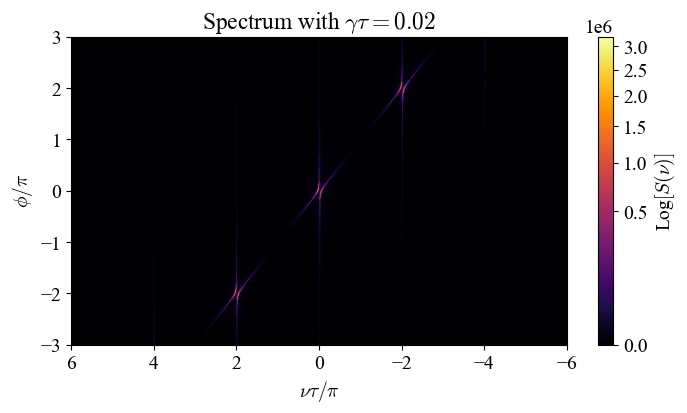

In [60]:
phi_values= np.linspace(-3*np.pi,3*np.pi,599)
gamma = 0.02
tau = 1

data = exp000(phi_values,gamma,tau)

In [61]:
t_resonance,e_resonance,a_resonance,s_resonance = run_simulation(gamma,tau,0,0,100,1e-2,[1,0])

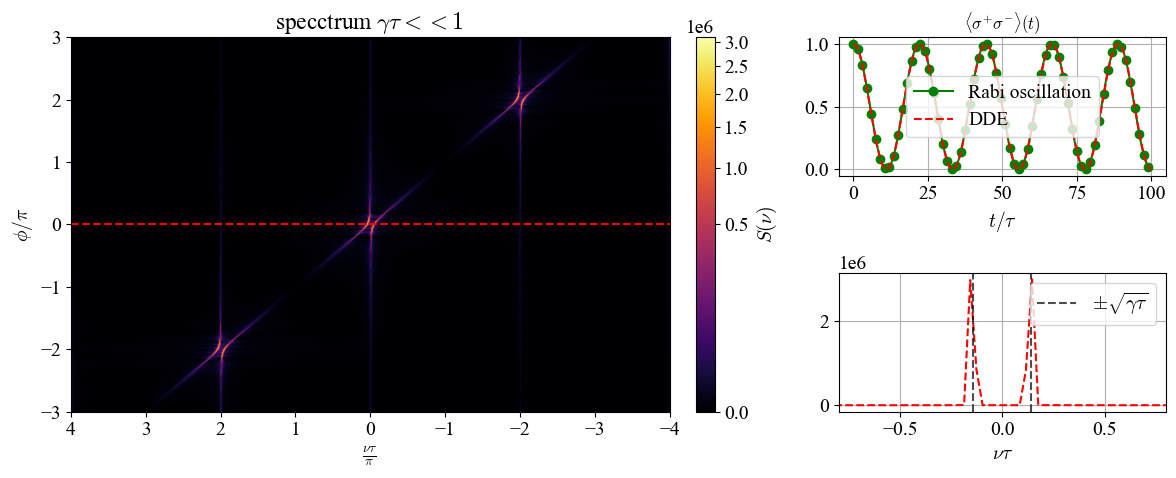

In [108]:
data_w=data[0]
data_u=data[1]

w_min = -4*np.pi/tau
w_max = 4*np.pi/tau
u_shifted = []
for n in range(len(phi_values)):
	w_ref = np.linspace(w_min,w_max,1000)+phi_values[n]/tau
	interp =interp1d(data_w[n,:],data_u[n,:])
	u_shifted.append(interp(w_ref))



map_plot = u_shifted
fig = plt.figure(figsize=(12, 5))
tau_s = 1.4
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)
ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow( map_plot,
					  origin='lower',
					  aspect='auto',
					  extent=[ w_min*tau/np.pi,w_max*tau/np.pi,phi_values[0]/np.pi,phi_values[-1]/np.pi],
					  norm=PowerNorm(gamma=0.38),
					  cmap='inferno' )
ax_heat.set_xlabel(r'$ \frac{\nu \tau}{\pi} $')
ax_heat.set_ylabel(r"$ \phi /\pi$")
ax_heat.set_title(r'specctrum $ \gamma \tau << 1 $ ')
ax_heat.axhline(y=0,color='r',linestyle="--")
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label(r"$S(\nu)$")
plt.gca().invert_xaxis()

ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(t_resonance,np.cos(np.sqrt(gamma)*t_resonance)**2,'g-o',label='Rabi oscillation',markevery=150)
ax_top.plot(t_resonance,e_resonance,'r--',label='DDE')
ax_top.set_title(r"$\langle \sigma^{+}\sigma^{-}\rangle(t) $",fontsize=12)
ax_top.set_xlabel(r"$t/\tau $")
ax_top.grid()
ax_top.legend()

ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.plot(data_w[298]+0.01,data_u[298],'r--')
ax_bottom.axvline(np.sqrt(gamma),linestyle='--',color='k',alpha=0.7)
ax_bottom.axvline(-np.sqrt(gamma),linestyle='--',color='k',alpha=0.7,label=r"$\pm \sqrt{\gamma \tau}$")
ax_bottom.set_xlim(-0.8,0.8)
ax_bottom.set_xlabel(r"$\nu\tau $")
ax_bottom.grid()
ax_bottom.legend()

plt.tight_layout()
plt.show()


In [133]:
t_off_resonance,e_off_resonance,a_off_resonance,s_off_resonance = run_simulation(gamma,tau,np.pi,0,100,1e-2,[1,0])
tmc=two_modes_cavity(np.pi/tau,0,2*np.pi,np.sqrt(gamma/tau),np.sqrt(gamma/tau),0,0,2)
vec=tmc.evolve(t_off_resonance)
e_off_resonance_exact=tmc.probability_excited(vec)

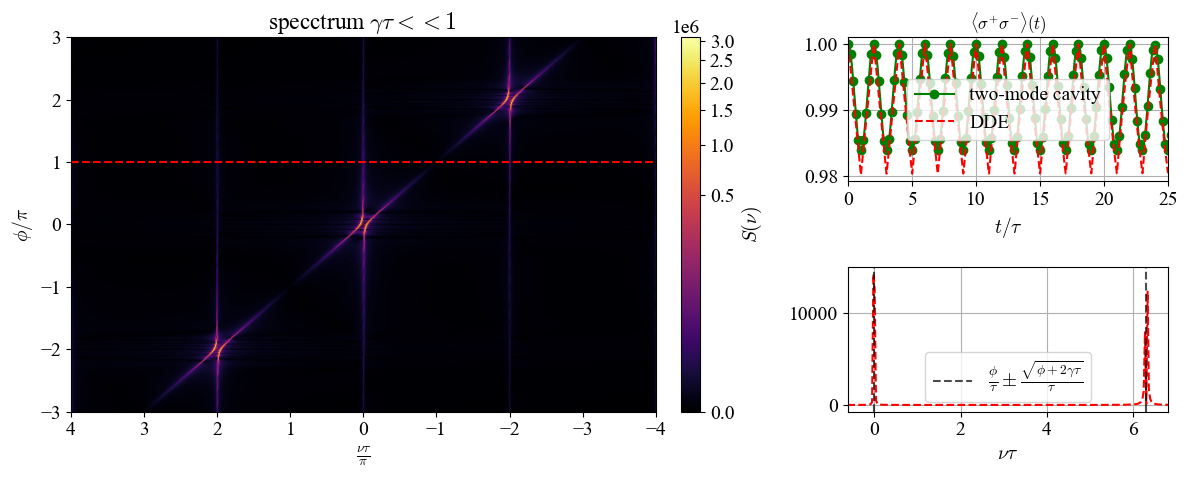

In [139]:
map_plot = u_shifted
fig = plt.figure(figsize=(12, 5))
tau_s = 1.4
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)
ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow( map_plot,
					  origin='lower',
					  aspect='auto',
					  extent=[ w_min*tau/np.pi,w_max*tau/np.pi,phi_values[0]/np.pi,phi_values[-1]/np.pi],
					  norm=PowerNorm(gamma=0.3),
					  cmap='inferno' )
ax_heat.set_xlabel(r'$ \frac{\nu \tau}{\pi} $')
ax_heat.set_ylabel(r"$ \phi /\pi$")
ax_heat.set_title(r'specctrum $ \gamma \tau << 1 $ ')
ax_heat.axhline(y=1,color='r',linestyle="--")
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label(r"$S(\nu)$")
plt.gca().invert_xaxis()

ax_top = fig.add_subplot(gs[0, 1])

ax_top.plot(t_off_resonance,e_off_resonance_exact,'g-o',label='two-mode cavity',markevery=20)
ax_top.plot(t_off_resonance,e_off_resonance,'r--',label='DDE')
ax_top.set_title(r"$\langle \sigma^{+}\sigma^{-}\rangle(t) $",fontsize=12)
ax_top.set_xlabel(r"$t/\tau $")
ax_top.grid()
ax_top.set_xlim(0,25)
ax_top.legend()

ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.plot(data_w[399]+np.pi,data_u[399],'r--')
ax_bottom.axvline(np.pi+np.sqrt(np.pi**2+2*gamma),linestyle='--',color='k',alpha=0.7)
ax_bottom.axvline(np.pi-np.sqrt(np.pi**2+2*gamma),linestyle='--',color='k',alpha=0.7,label=r"$\frac{\phi}{\tau}\pm \frac{\sqrt{\phi+2\gamma\tau}}{\tau}$")
ax_bottom.set_xlim(-0.6,6.8)
ax_bottom.set_xlabel(r"$\nu\tau $")
ax_bottom.grid()
ax_bottom.legend()

plt.tight_layout()
plt.show()

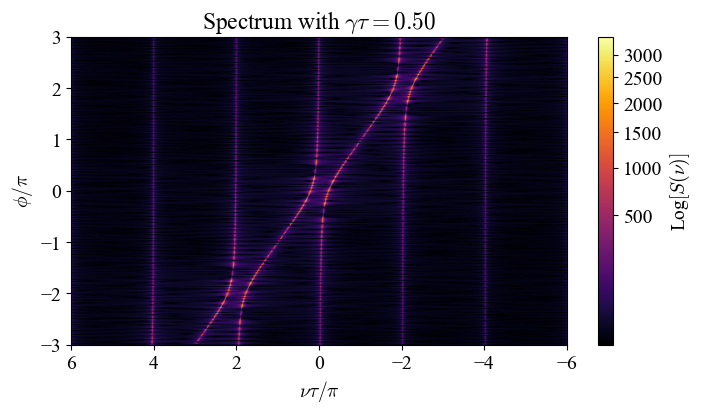

In [5]:
phi_values= np.linspace(-3*np.pi,3*np.pi,250)
gamma = 0.5
tau = 1

_,_ = exp000(phi_values,gamma,tau)

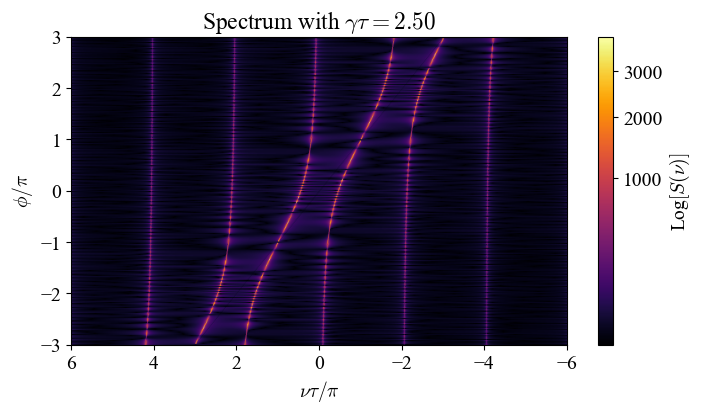

In [6]:
phi_values= np.linspace(-3*np.pi,3*np.pi,250)
gamma = 2.5
tau = 1

_,_ = exp000(phi_values,gamma,tau)

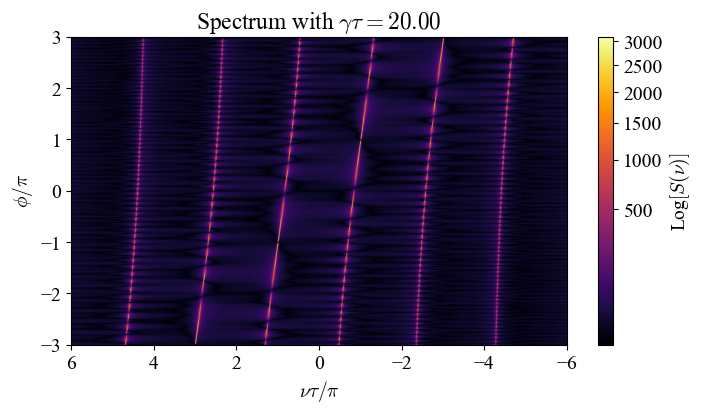

In [7]:
phi_values= np.linspace(-3*np.pi,3*np.pi,250)
gamma = 20
tau = 1

_,_ = exp000(phi_values,gamma,tau)

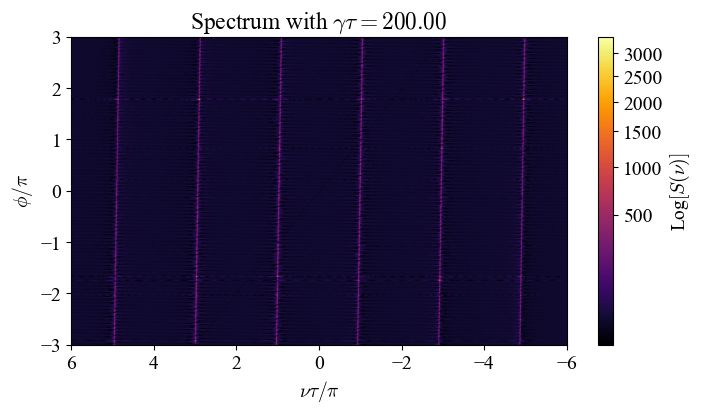

In [8]:
phi_values= np.linspace(-3*np.pi,3*np.pi,250)
gamma = 200
tau = 1

_,_ = exp000(phi_values,gamma,tau)

# 2. Spectrum as you increase $\gamma \tau$ and vary $\phi$ 

I am first going to look at the resonant case, which is the one that seems to work best 

In [307]:
def exp001(gamma_values,phi_s):
	tau_s = 1 
	initial = [1,0]
	t_max = 270 * tau_s
	dt = tau_s/100 
	Ms = np.arange(15000,16000,1)

	def sample_gamma(gamma_value):
		t,_,a,_ = run_simulation(gamma_value,tau_s,phi_s,0,t_max,dt,initial,Ms)   # not the same using S or U, need to look into it
		w,aw = fft_matrix(t,a)
		u = observable(aw,initial)
		return w,u
	
	data = paralelizar(gamma_values,sample_gamma)
	data_w = np.asarray([data_f[0] for data_f in data])
	data_u = np.abs(np.asarray([np.abs(np.real(data_f[1])) for data_f in data]))
	return data_w,data_u

In [308]:
gamma_values = np.linspace(0.05,10,1000)

dataw,datau = exp001(gamma_values,0)

In [310]:
np.savez("datos_spec_gamma_29_10.npz", dataw=dataw, datau=datau)

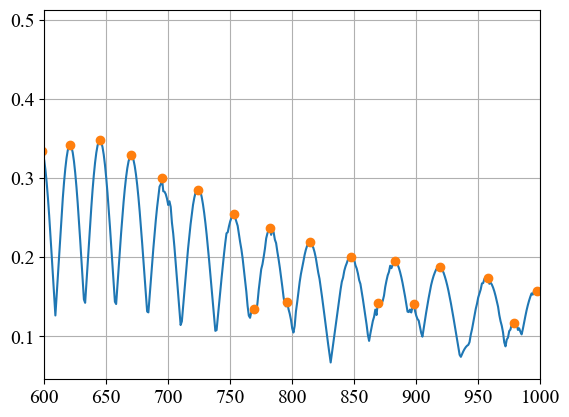

In [292]:
max_u = []
max_w=[]
datau_normalized=[]
for n in range(datau.shape[0]):
    dummie=datau[n,:]/np.sum(np.abs(datau[n,:]))
    datau_normalized.append(dummie)
    max_u.append(np.max(dummie[dataw[n,:]>0]))

datau_normalized=np.asarray(datau_normalized)    
max_u=np.asarray(max_u)

peaks_max,_ = find_peaks(max_u,distance=10)
plt.plot(max_u)
plt.plot(np.arange(len(max_u))[peaks_max],max_u[peaks_max],'o')
plt.grid()
plt.xlim(600,1000)
plt.show()

In [293]:
peaks_max

array([  3,  13,  25,  39,  49,  61,  74,  84,  94, 105, 117, 129, 143,
       155, 170, 185, 202, 220, 230, 240, 250, 260, 271, 282, 293, 305,
       317, 330, 343, 356, 370, 385, 400, 410, 426, 442, 459, 477, 495,
       514, 534, 554, 576, 598, 621, 645, 670, 695, 724, 753, 769, 782,
       796, 814, 847, 869, 883, 898, 919, 958, 979, 997])

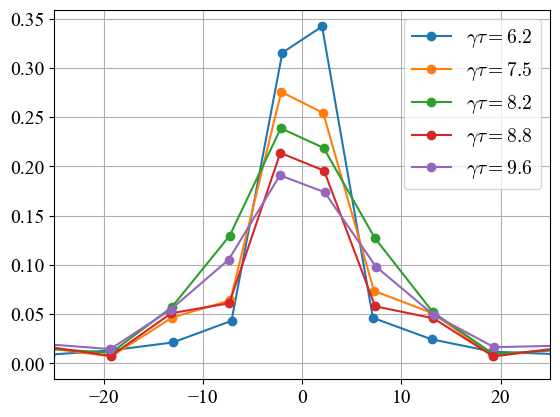

In [304]:
index = [621,753,814,883,958]

for idx in index:
    peaks,_ = find_peaks(datau_normalized[idx,:],distance=170)
    plt.plot(dataw[idx,peaks],datau_normalized[idx,peaks],'-o',label=rf"$\gamma \tau ={gamma_values[idx]:.1f}$")
    plt.xlim(-25,25)
plt.legend()
plt.grid()
plt.savefig('lorentzian_approach.pdf')
plt.show()

/home/carlosb/Documents/python_projects/Non_markovian_cavity/Non_markovian_cavity/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/carlosb/Documents/python_projects/Non_markovian_cavity/Non_markovian_cavity/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


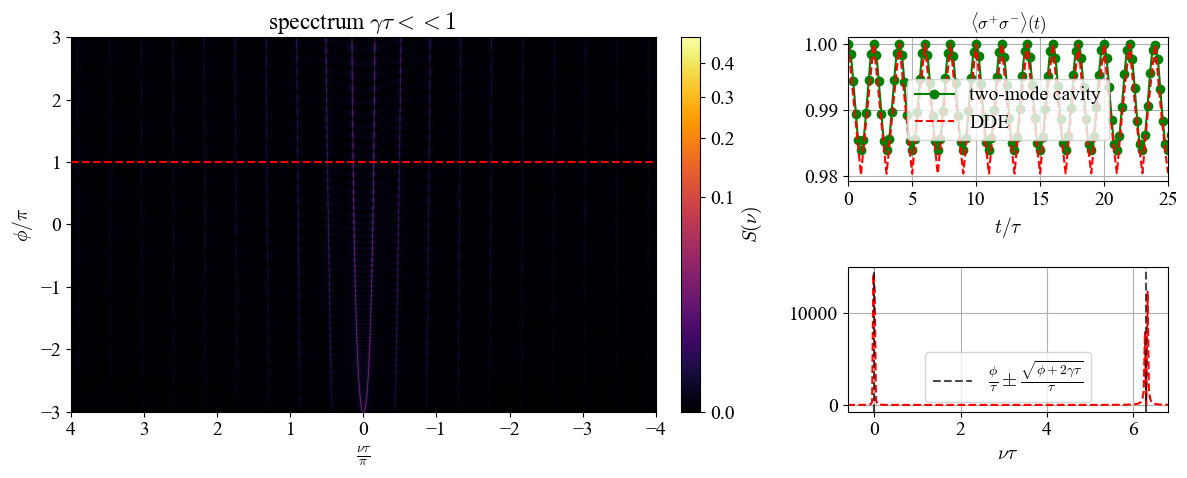

In [305]:
map_plot = datau_normalized
fig = plt.figure(figsize=(12, 5))
tau_s = 1.4
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)
ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow( map_plot,
					  origin='lower',
					  aspect='auto',
					  extent=[ w_min*tau/np.pi,w_max*tau/np.pi,phi_values[0]/np.pi,phi_values[-1]/np.pi],
					  norm=PowerNorm(gamma=0.35),
					  cmap='inferno' )
ax_heat.set_xlabel(r'$ \frac{\nu \tau}{\pi} $')
ax_heat.set_ylabel(r"$ \phi /\pi$")
ax_heat.set_title(r'specctrum $ \gamma \tau << 1 $ ')
ax_heat.axhline(y=1,color='r',linestyle="--")
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label(r"$S(\nu)$")
plt.gca().invert_xaxis()

ax_top = fig.add_subplot(gs[0, 1])

ax_top.plot(t_off_resonance,e_off_resonance_exact,'g-o',label='two-mode cavity',markevery=20)
ax_top.plot(t_off_resonance,e_off_resonance,'r--',label='DDE')
ax_top.set_title(r"$\langle \sigma^{+}\sigma^{-}\rangle(t) $",fontsize=12)
ax_top.set_xlabel(r"$t/\tau $")
ax_top.grid()
ax_top.set_xlim(0,25)
ax_top.legend()

ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.plot(data_w[399]+np.pi,data_u[399],'r--')
ax_bottom.axvline(np.pi+np.sqrt(np.pi**2+2*gamma),linestyle='--',color='k',alpha=0.7)
ax_bottom.axvline(np.pi-np.sqrt(np.pi**2+2*gamma),linestyle='--',color='k',alpha=0.7,label=r"$\frac{\phi}{\tau}\pm \frac{\sqrt{\phi+2\gamma\tau}}{\tau}$")
ax_bottom.set_xlim(-0.6,6.8)
ax_bottom.set_xlabel(r"$\nu\tau $")
ax_bottom.grid()
ax_bottom.legend()

plt.tight_layout()
plt.show()

# 2. Similarities with Jaynes-cummings ($\gamma \tau \approx 0 $)

# 3. discrepancies with many-mode ($\gamma \tau \to \infty $)